In [1]:
import pandas as pd

df = pd.read_csv('/content/Daily_Demand_Forecasting_Orders.csv', sep=';')

#df=df.drop(columns = ['date'])
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=2)
#df = imputer.fit_transform(df)

'''
df=df.dropna()
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le1 = LabelEncoder()
le2 = LabelEncoder()
'''


#df['icon']= le.fit_transform(df['icon'])

y = df['Target (Total orders)'].values
df=df.drop(columns = ['Target (Total orders)'])
X = df.values


In [ ]:
df

In [2]:

y=y.reshape(-1, 1)


import numpy as np
X=np.concatenate((X[1:], y[0:-1]), axis=1)

In [7]:
pip install keras-self-attention

  Created wheel for keras-self-attention: filename=keras_self_attention-0.51.0-py3-none-any.whl size=18912 sha256=d9239fc7fe51bf4f9cdbaa5ea16855eb7d4f4c51cb788fae3eb0db7ec387bc00
  Stored in directory: /root/.cache/pip/wheels/95/b1/a8/5ee00cc137940b2f6fa198212e8f45d813d0e0d9c3a04035a3
Successfully built keras-self-attention


In [3]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X= sc.fit_transform(X)

In [8]:
pip install pyrcn

     |████████████████████████████████| 81 kB 6.1 MB/s 


In [4]:
from sklearn.model_selection import train_test_split
x_train1, x_test1, y_train1, y_test1 = train_test_split(X, y[1:], test_size=0.2, shuffle=False, random_state=42)


In [12]:
x_train1.shape

(47, 13)

In [5]:
from pyrcn.base.blocks import InputToNode
from sklearn . datasets import make_blobs
# Generate a toy dataset

In [6]:
input_to_node = InputToNode (25, input_activation='relu',input_scaling =1.0 )


x_train= input_to_node.fit_transform (x_train1)
x_test= input_to_node.transform (x_test1)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:77: FutureWarning: Pass hidden_layer_size=25 as keyword args. From version 1.1 (renaming of 0.26) passing these as positional arguments will result in an error
  FutureWarning,


In [7]:
from pyrcn.base.blocks import NodeToNode
node_to_node = NodeToNode (25, reservoir_activation='relu', spectral_radius =1.0 , leakage =0.8 ,bidirectional = False )
x_train=node_to_node . fit_transform(x_train)
x_test= node_to_node.transform (x_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:77: FutureWarning: Pass hidden_layer_size=25 as keyword args. From version 1.1 (renaming of 0.26) passing these as positional arguments will result in an error
  FutureWarning,


In [8]:
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

x_train1 = x_train1.reshape((x_train1.shape[0], x_train1.shape[1], 1))
x_test1 = x_test1.reshape((x_test1.shape[0], x_test1.shape[1], 1))

In [9]:
from tensorflow import keras
from tensorflow.keras import layers

In [10]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [11]:
from keras_self_attention import SeqSelfAttention
def build_model(
    input_shapey,
    input_shapez,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputsy = keras.Input(shape=input_shapey)
    inputsz = keras.Input(shape=input_shapez)
    y = inputsy
    z= inputsz

    #z=layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(z)

    #y=layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(y)

    z=SeqSelfAttention()(z)

    #y=SeqSelfAttention()(y)



    x=layers.Concatenate(axis=1)([y, z])
    #x=layers.Add()([inputsy, inputsz])

    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    #outputs = layers.Dense(5, activation="softmax")(x)
    outputs = layers.Dense(1)(x)
    return keras.Model([inputsy,inputsz], outputs)

In [12]:
input_shapey = x_train1.shape[1:]
input_shapez = x_train.shape[1:]

model = build_model(
    input_shapey,
    input_shapez,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

model.compile(
    loss="mean_absolute_error",
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    metrics=["mean_absolute_error"],
)
'''
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    metrics=["sparse_categorical_accuracy"],
)
'''
model.summary()





Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 25, 1)]      0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 13, 1)]      0           []                               
                                                                                                  
 seq_self_attention (SeqSelfAtt  (None, 25, 1)       129         ['input_2[0][0]']                
 ention)                                                                                          
                                                                                                  
 concatenate (Concatenate)      (None, 38, 1)        0           ['input_1[0][0]',            

In [18]:
model.compile(
    loss="mean_absolute_error",
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    metrics=["mean_absolute_error"],
)
callbacks = [keras.callbacks.EarlyStopping(patience=300, restore_best_weights=True)]

history=model.fit(
    [x_train1,x_train],
    y_train1,
    validation_data=([x_test1, x_test], y_test1),
    epochs=2000,
    batch_size=128,
    callbacks=callbacks,
)

Epoch 1/2000
1/1 [==============================] - 8s 8s/step - loss: 23.8379 - mean_absolute_error: 23.8379 - val_loss: 19.9064 - val_mean_absolute_error: 19.9064
Epoch 2/2000
1/1 [==============================] - 0s 67ms/step - loss: 27.7312 - mean_absolute_error: 27.7312 - val_loss: 19.8256 - val_mean_absolute_error: 19.8256
Epoch 3/2000
1/1 [==============================] - 0s 50ms/step - loss: 31.1748 - mean_absolute_error: 31.1748 - val_loss: 19.8631 - val_mean_absolute_error: 19.8631
Epoch 4/2000
1/1 [==============================] - 0s 64ms/step - loss: 28.9291 - mean_absolute_error: 28.9291 - val_loss: 19.8307 - val_mean_absolute_error: 19.8307
Epoch 5/2000
1/1 [==============================] - 0s 50ms/step - loss: 29.4947 - mean_absolute_error: 29.4947 - val_loss: 19.8458 - val_mean_absolute_error: 19.8458
Epoch 6/2000
1/1 [==============================] - 0s 52ms/step - loss: 22.6679 - mean_absolute_error: 22.6679 - val_loss: 20.3846 - val_mean_absolute_error: 20.3846


In [19]:
#testing prediction

#testing prediction
ypred=model.predict([x_test1, x_test])
#testing prediction

#testing prediction

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score, max_error, mean_squared_log_error, mean_poisson_deviance, mean_gamma_deviance
print('mse: ', mean_squared_error(ypred, y_test1))
print('mae: ', mean_absolute_error(ypred, y_test1))
print('r2_score: ', r2_score(ypred, y_test1))
print('explained_variance_score: ', explained_variance_score(ypred, y_test1))
print('max_error: ', max_error(ypred, y_test1))
#print('mean_squared_log_error: ', mean_squared_log_error(ypred, y_test1))
print('mean_poisson_deviance: ', r2_score(ypred, y_test1))
#print('mean_gamma_deviance: ',  mean_gamma_deviance(ypred, y_test1))


mse:  1082.296303825206
mae:  18.880815124511727
r2_score:  0.5733479913145574
explained_variance_score:  0.5758784660359186
max_error:  104.44891894531253
mean_poisson_deviance:  0.5733479913145574


In [20]:
#training prediction
xpred=model.predict([x_train1, x_train])
print('mse: ', mean_squared_error(xpred, y_train1))
print('mae: ', mean_absolute_error(xpred, y_train1))
print('r2_score: ', r2_score(xpred, y_train1))
print('explained_variance_score: ', explained_variance_score(xpred, y_train1))
print('max_error: ', max_error(xpred, y_train1))
#print('mean_squared_log_error: ', mean_squared_log_error(xpred, y_train1))
print('mean_poisson_deviance: ', r2_score(xpred, y_train1))
#print('mean_gamma_deviance: ',  mean_gamma_deviance(xpred, y_train1))

mse:  67.64526939536232
mae:  6.081021110372337
r2_score:  0.9909584420622278
explained_variance_score:  0.9937946960115416
max_error:  31.030936279296895
mean_poisson_deviance:  0.9909584420622278


In [21]:
xx=[]
for i in range(len(ypred)):
    xx.append(i)

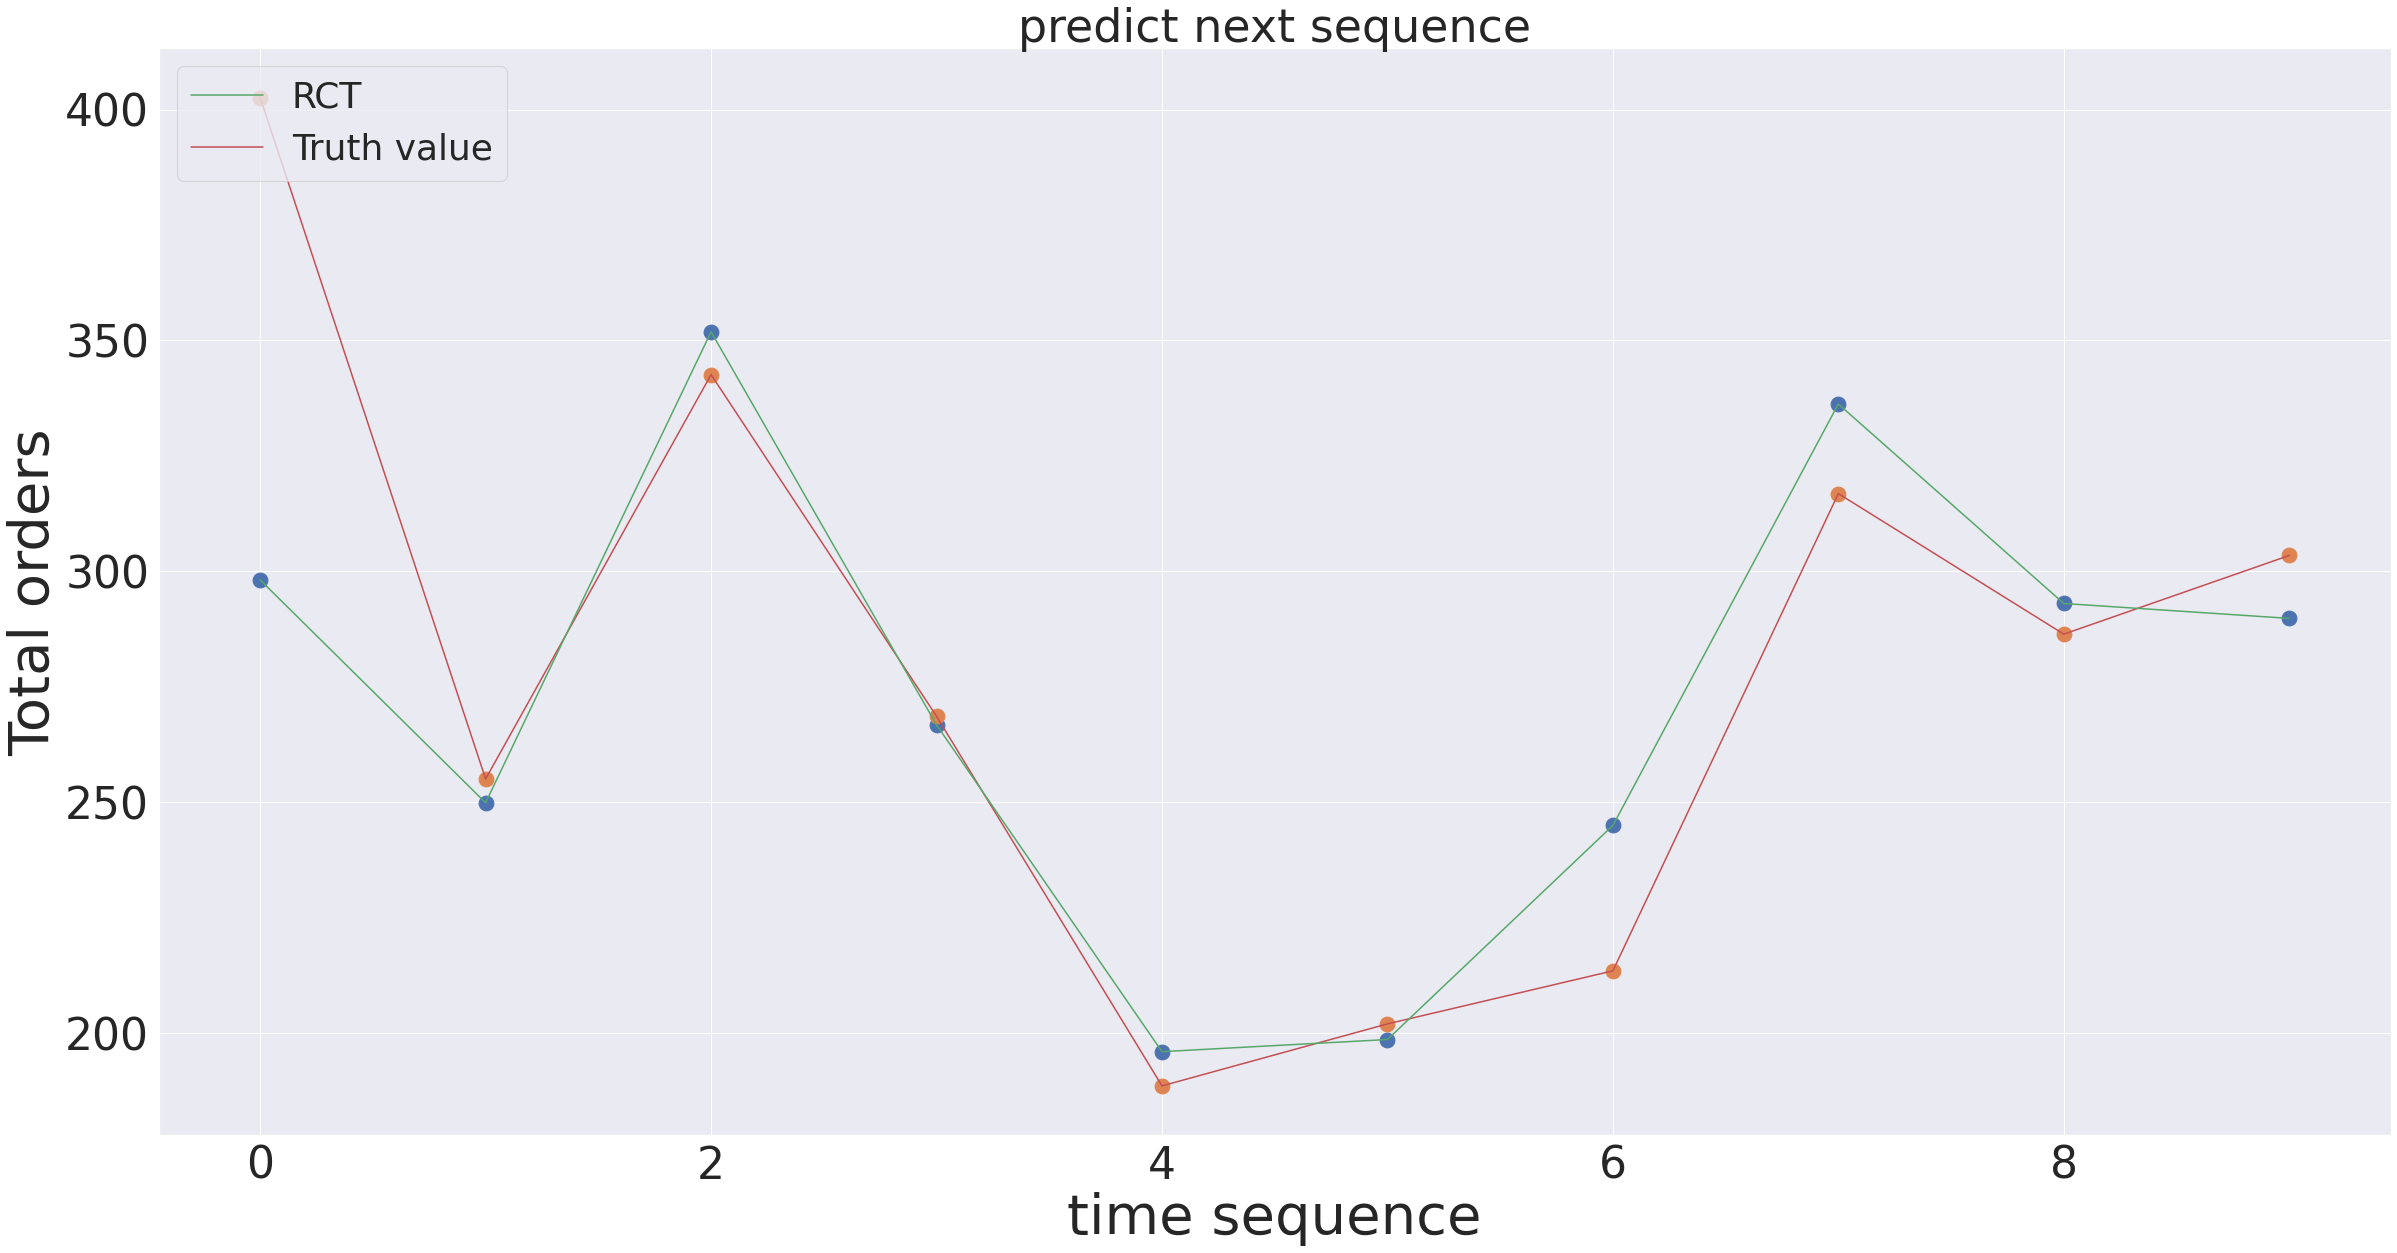

In [22]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [40, 20]
i=0
j=10
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale = 4)
plt.figure()
plt.plot(xx[i:j],ypred[i:j], color='g', label='RCT', zorder=10)
plt.plot(xx[i:j],y_test1[i:j], color='r', label='Truth value')

plt.scatter(xx[i:j],ypred[i:j],  s=220, zorder=2)
plt.scatter(xx[i:j],y_test1[i:j],  s=220, zorder=2)

plt.legend(loc="upper left", fontsize=36)
plt.title('predict next sequence', fontsize=46)
plt.xlabel('time sequence', fontsize=56)
plt.ylabel('Total orders', fontsize=56)
plt.show()

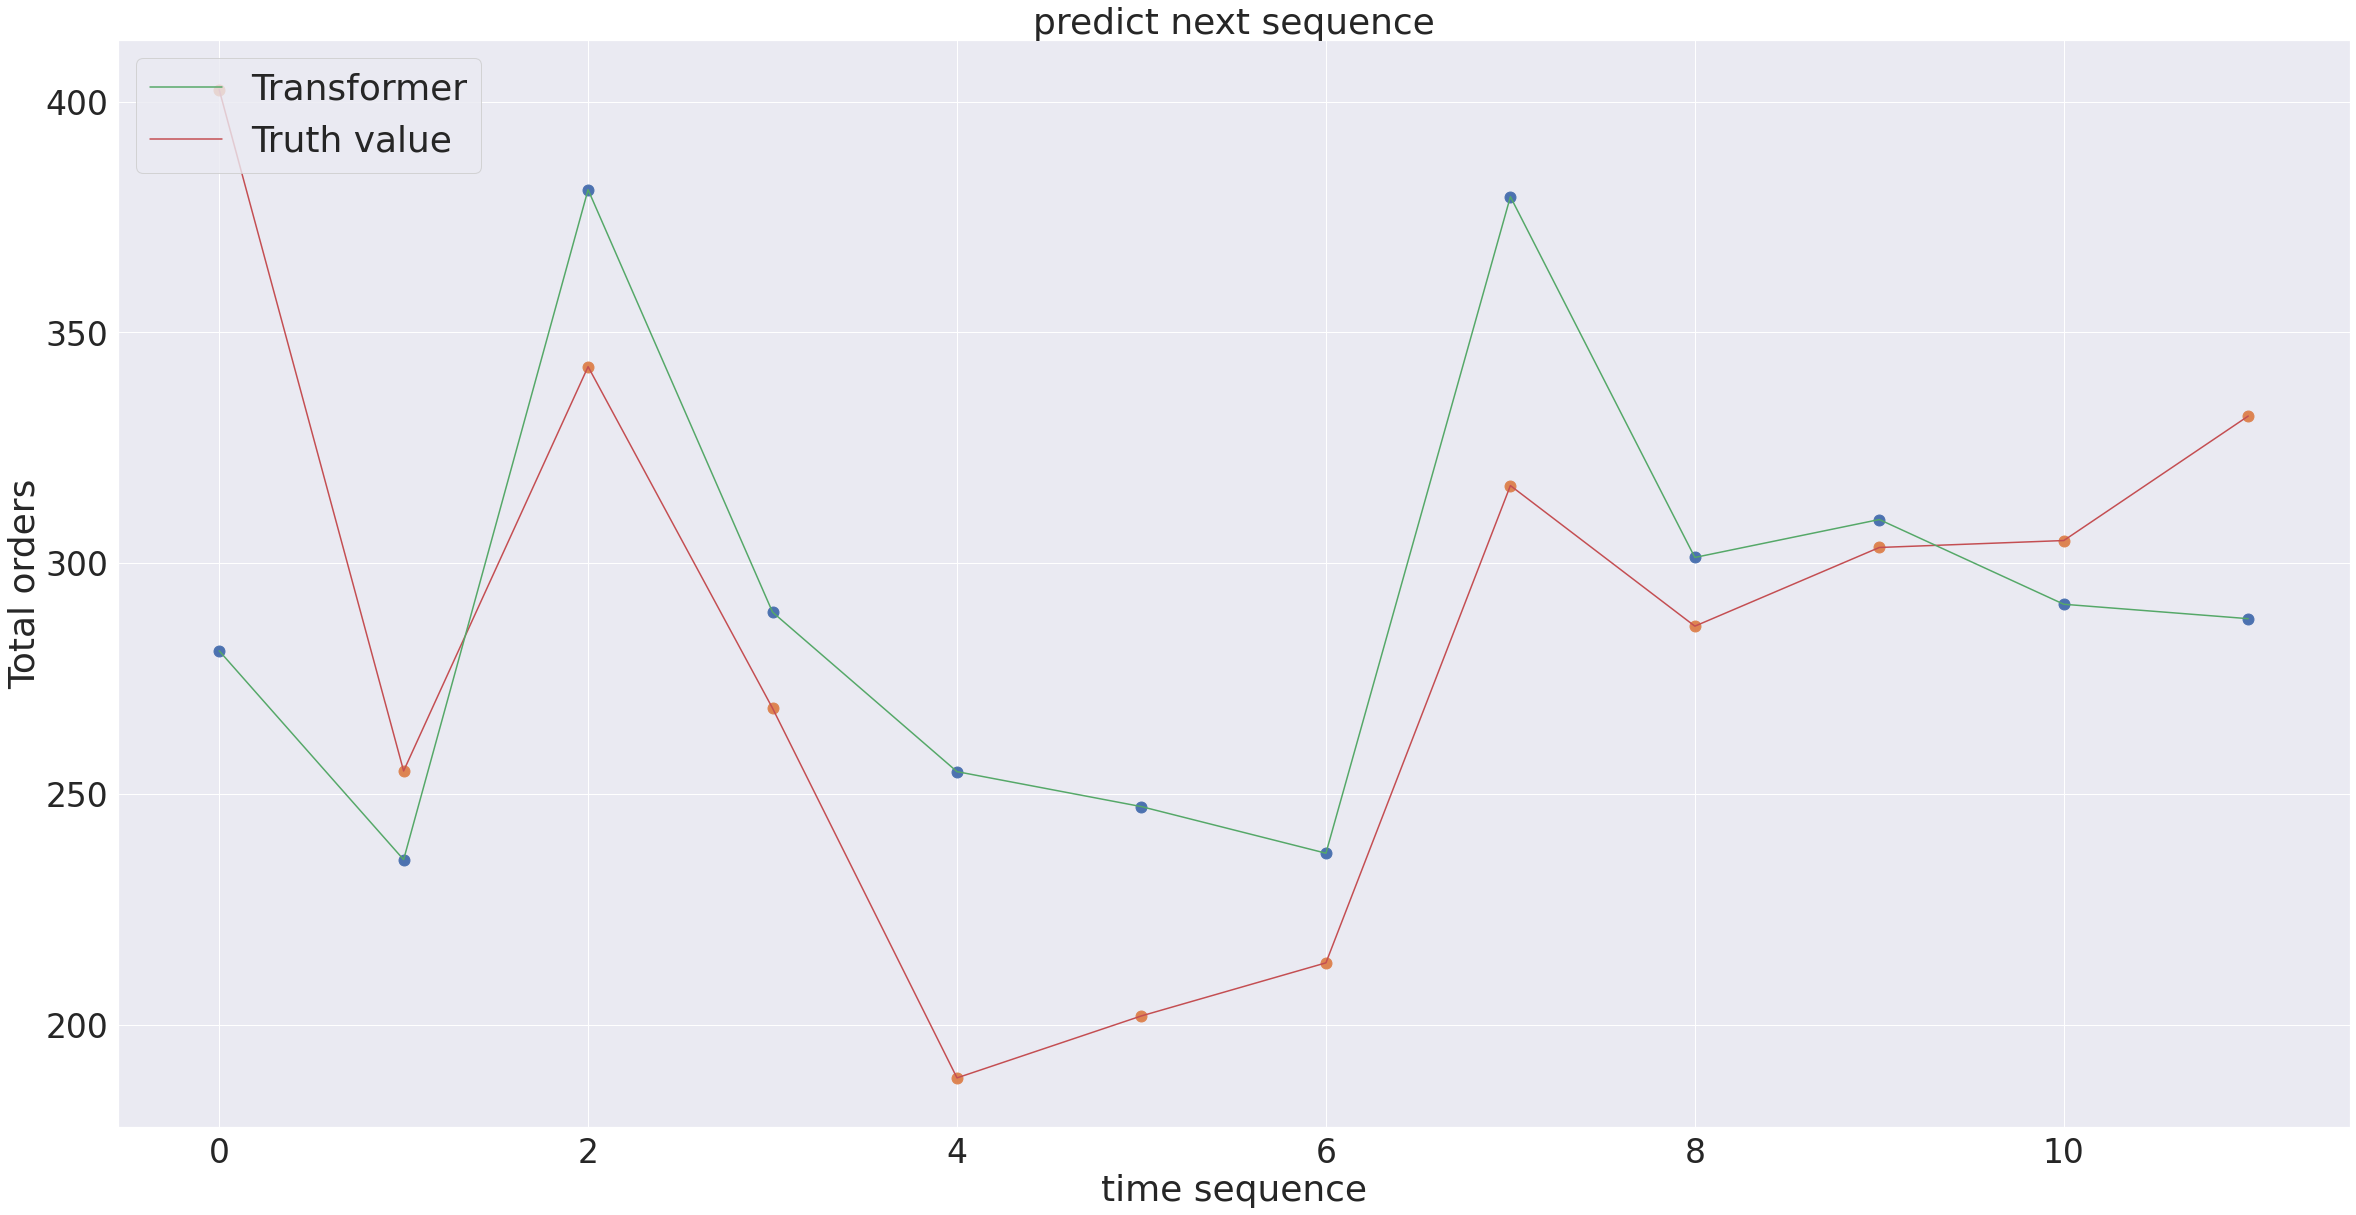

In [26]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [40, 20]
i=0
j=100
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale = 3)
plt.figure()
plt.plot(xx[i:j],trans_y_predict[i:j], color='g', label='Transformer', zorder=10)
plt.plot(xx[i:j],y_test1[i:j], color='r', label='Truth value')

plt.scatter(xx[i:j],trans_y_predict[i:j],  s=120, zorder=2)
plt.scatter(xx[i:j],y_test1[i:j],  s=120, zorder=2)

plt.legend(loc="upper left", fontsize=36)
plt.title('predict next sequence', fontsize=36)
plt.xlabel('time sequence', fontsize=36)
plt.ylabel('Total orders', fontsize=36)
plt.show()

In [25]:
import pickle
with open('/content/trans_y_predict.pickle', 'rb') as handle:
    trans_y_predict = pickle.load(handle)

with open('/content/trans_x_predict.pickle', 'rb') as handle:
    trans_x_predict = pickle.load(handle)

*** compare for the testing data***

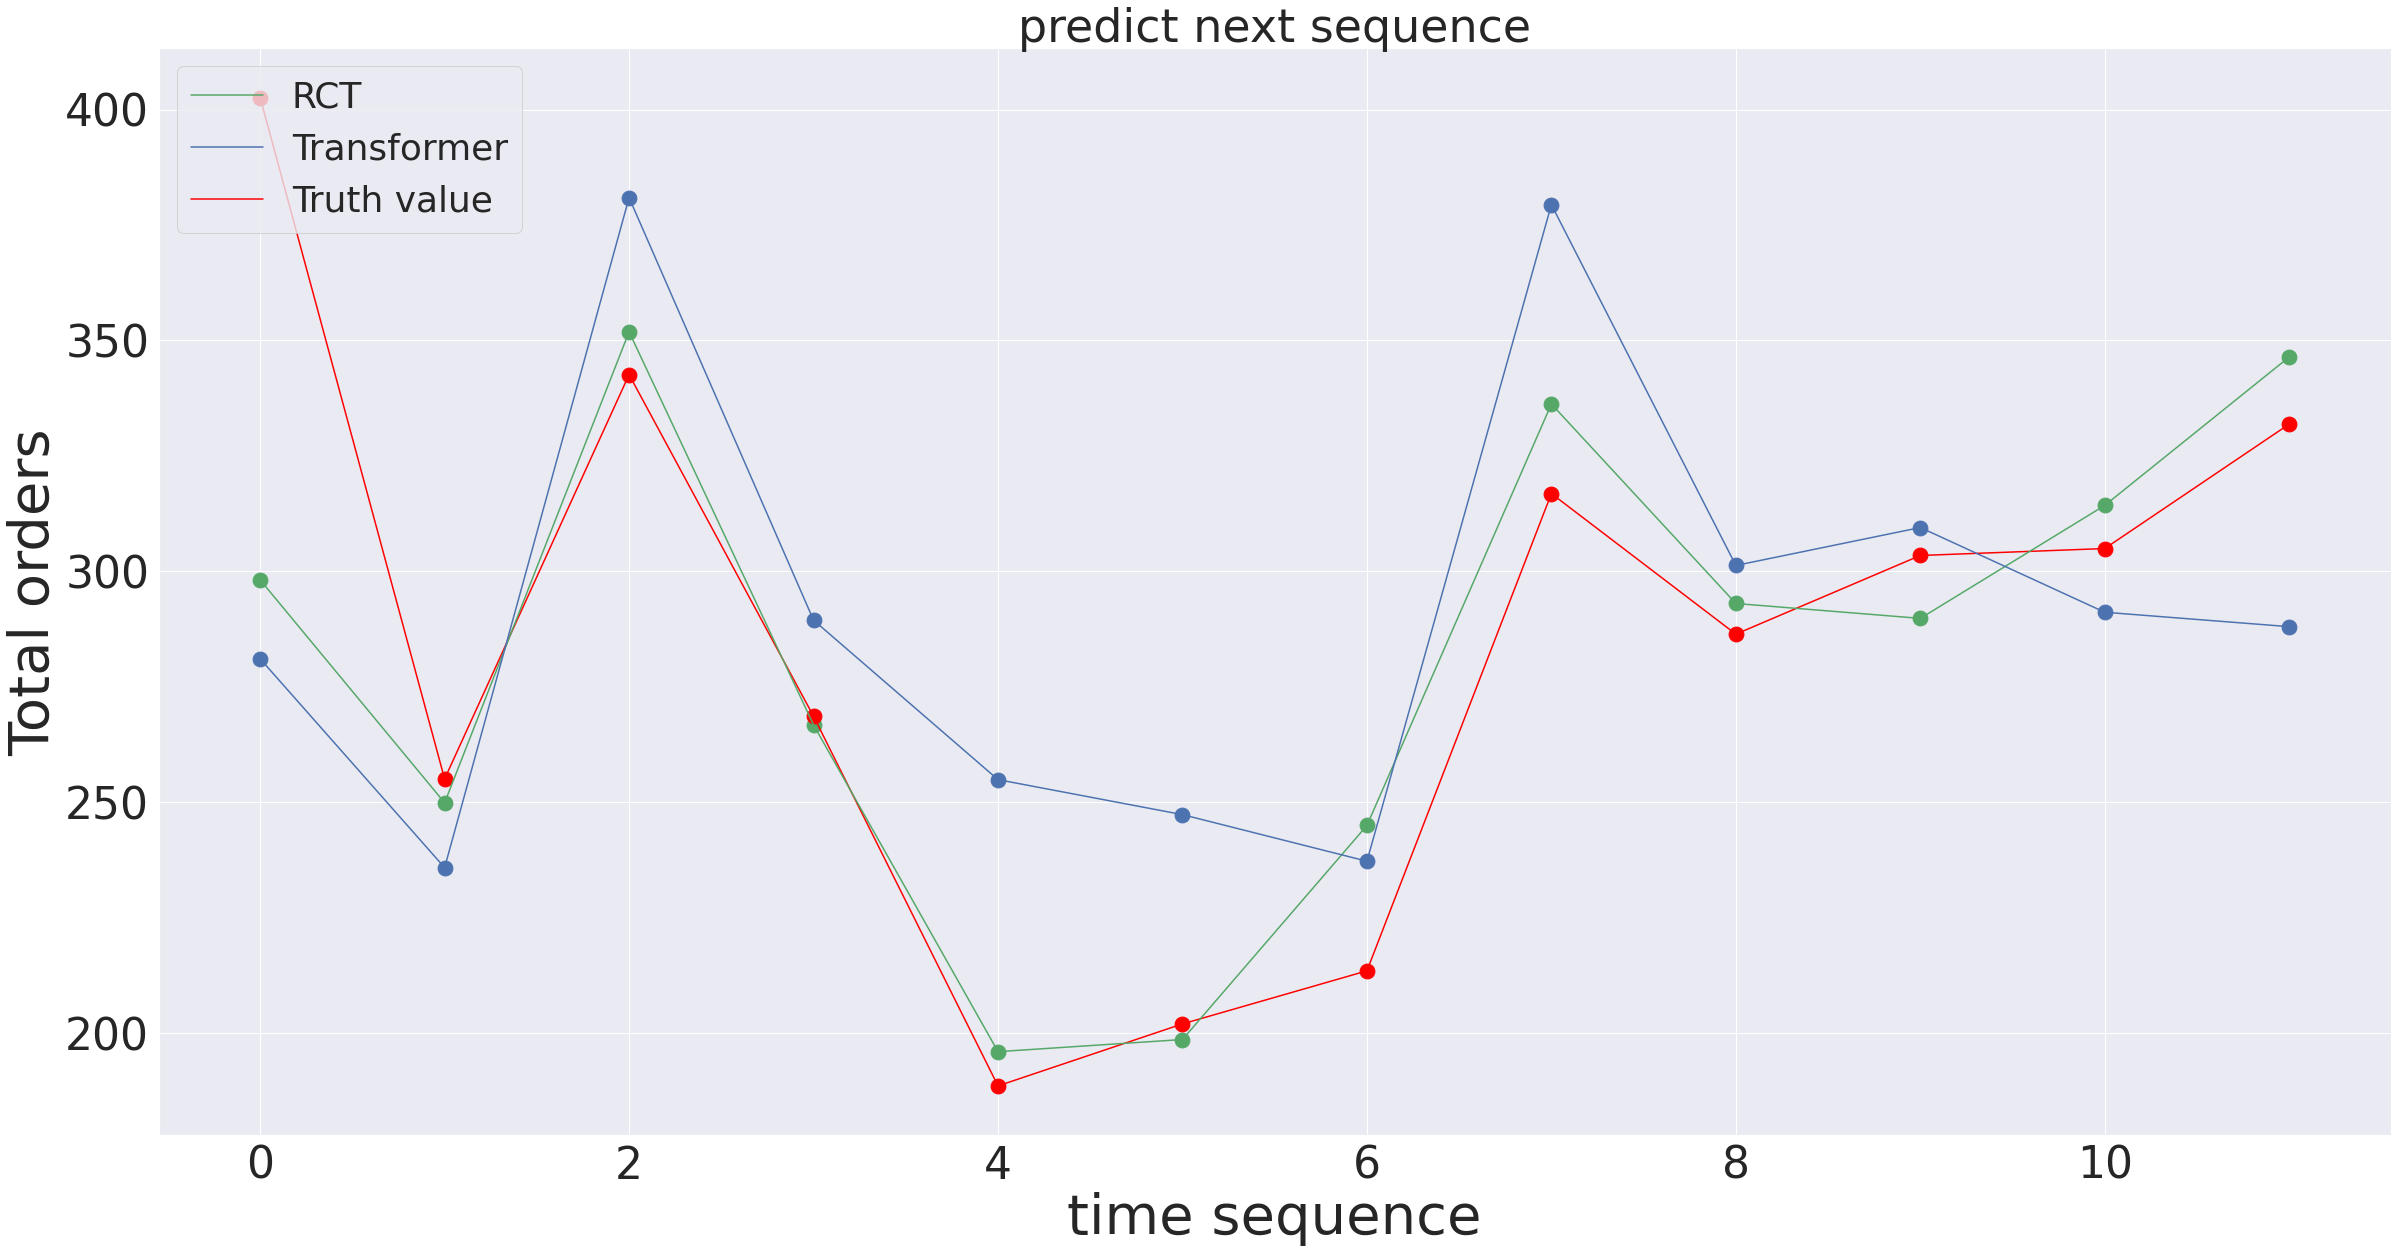

In [27]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [40, 20]
i=0
j=80
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale = 4)
plt.figure()
plt.plot(xx[i:j],ypred[i:j], color='g', label='RCT', zorder=10)
plt.plot(xx[i:j],trans_y_predict[i:j], color='b', label='Transformer', zorder=10)
plt.plot(xx[i:j],y_test1[i:j], color='red', label='Truth value')

plt.scatter(xx[i:j],ypred[i:j], color='g', s=220, zorder=2)
plt.scatter(xx[i:j],trans_y_predict[i:j], color='b', s=220, zorder=2)
plt.scatter(xx[i:j],y_test1[i:j],  s=220,color='red', zorder=2)

plt.legend(loc="upper left", fontsize=36)
plt.title('predict next sequence', fontsize=46)
plt.xlabel('time sequence', fontsize=56)
plt.ylabel('Total orders', fontsize=56)
plt.show()